In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark import SparkContext
sc = SparkContext(master="local", appName="New Spark Context")

In [3]:
from pyspark.sql import Row, SQLContext
from pyspark.sql import SparkSession
spark = SparkSession(sc)

In [4]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from datetime import datetime
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import regexp_extract, col

In [5]:
df = spark.read.csv("Cung cap du lieu buoi 4/2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

In [6]:
df_sub = df.select('STREETNUMBERNUMERIC', 'FIREPLACES', 
                   'LOTSIZEDIMENSIONS', 'LISTTYPE', 'ACRES', 
                   'ASSUMABLEMORTGAGE', 'SalesClosePrice', 'ListPrice',
                   'DAYSONMARKET')
df_sub.show(5)

+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
|STREETNUMBERNUMERIC|FIREPLACES|LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
|              11511|         0|          279X200|Exclusive Right| 1.28|             null|         143000|   139900|          10|
|              11200|         0|          100x140|Exclusive Right| 0.32|             null|         190000|   210000|           4|
|               8583|         0|          120x296|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|
|               9350|         1|          208X208|Exclusive Right| 0.94|             null|         265000|   230000|          19|
|               2915|         1|          116x200|Exclusive Right|  0.0|             null|

In [7]:
# Drop columns in list
df_sub = df_sub.drop(*['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS'])
df_sub.show(5)

+----------+---------------+-----+-----------------+---------------+---------+------------+
|FIREPLACES|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|
+----------+---------------+-----+-----------------+---------------+---------+------------+
|         0|Exclusive Right| 1.28|             null|         143000|   139900|          10|
|         0|Exclusive Right| 0.32|             null|         190000|   210000|           4|
|         0|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|
|         1|Exclusive Right| 0.94|             null|         265000|   230000|          19|
|         1|Exclusive Right|  0.0|             null|         249900|   239900|          21|
+----------+---------------+-----+-----------------+---------------+---------+------------+
only showing top 5 rows



In [8]:
# Inspect unique values in  the column 'ASSUMABLEMORTGAGE'
df_sub.select(['ASSUMABLEMORTGAGE']).distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+



In [9]:
print('Before:', df_sub.count())
# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df_sub but keep null values
text_filter= ~df_sub['ASSUMABLEMORTGAGE'].isin(yes_values) | df_sub['ASSUMABLEMORTGAGE'].isNull()
df_sub = df.where(text_filter)

# print count of remaining records
print('After:', df_sub.count())

Before: 5000
After: 4976


In [10]:
df_sub = df_sub.withColumn('log_SalesClosePrice', log(col('SalesClosePrice')))

In [11]:
df_sub.count()

4976

In [12]:
# Calculate values used for outlier filtering
mean_val = df_sub.agg({'log_SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = df_sub.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]

# Create three standard deviation (μ + 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df_sub = df_sub.where((df_sub['log_SalesClosePrice'] < hi_bound) & (df_sub['log_SalesClosePrice'] > low_bound))

In [13]:
df_sub.count()

4946

In [14]:
# drop records if both ListPrice and SalesClosePrice are NULL
df_sub = df_sub.dropna(how='all', subset=['ListPrice', 'SalesClosePrice'])

In [15]:
# Drop any records with NULL values
#df_sub = df_sub.dropna()

# Drop records where at least two columns have NULL values
#df_sub = df_sub.dropna(thresh=2)

In [16]:
df_sub.count()

4946

In [17]:
df_sub = df_sub.drop_duplicates()

In [18]:
df_sub.count()

4946

In [19]:
# Calc max and min for new column
print(df_sub.agg({'SalesClosePrice': 'max'}).collect())
print(df_sub.agg({'SalesClosePrice': 'min'}).collect())

# Define max and min values and collect them
max_price = df_sub.agg({'SalesClosePrice': 'max'}).collect()[0][0]
min_price = df_sub.agg({'SalesClosePrice': 'min'}).collect()[0][0]

# Create a new column based off the scaled data
df_sub = df_sub.withColumn('scaled_price',
                          (df['SalesClosePrice'] - min_price)/(max_price - min_price))

# Calc max and min for new column
print(df_sub.agg({'scaled_price':'max'}).collect())
print(df_sub.agg({'scaled_price':'min'}).collect())

[Row(max(SalesClosePrice)=920000)]
[Row(min(SalesClosePrice)=61000)]
[Row(max(scaled_price)=1.0)]
[Row(min(scaled_price)=0.0)]


In [20]:
df_sub.select('scaled_price').show(5)

+-------------------+
|       scaled_price|
+-------------------+
|0.15366705471478465|
| 0.2060535506402794|
|  0.220023282887078|
|0.10593713620488941|
|0.10360884749708964|
+-------------------+
only showing top 5 rows



In [21]:
roof = df[['ROOF']]

In [23]:
roof.where(df['ROOF'].isNull()).count()

765

In [24]:
roof_df = roof.toPandas()

<AxesSubplot:>

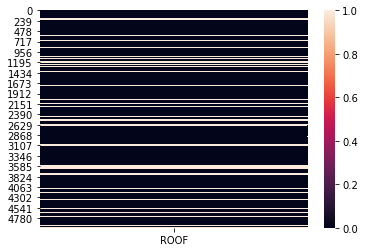

In [25]:
sns.heatmap(data=roof_df.isnull())

In [27]:
# Ratio of null value to data
roof.where(df['ROOF'].isNull()).count()/roof.count()

0.153

In [28]:
def column_dropper(df, threshold):
    # Takes a dataframe and threshold for missing values. 
    # Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
        # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
        # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

In [29]:
# Drop columns that are more than 70% missing
df = column_dropper(df, 0.7)

In [30]:
df.count()

5000